Ridge Regression

Assume a centered linear regression model where the data have been pre-processed so that the mean of each feature (and the target) is zero. This means we don’t need a separate intercept term, simplifying the model to:

$$f(x_i) = \sum_{j=1}^p x_{ij} \beta_j$$

## Constrained Formulation

Ridge regression can be understood through a constrained optimization approach. We seek to minimize the residual sum of squares, subject to a constraint that limits the magnitude of the coefficients:

$$
\begin{align*}
&\min_{\beta}  \sum_{i=1}^N \left( \sum_{j=1}^p x_{ij} \beta_j - y_i \right)^2 \
&\text{subject to} \quad \sum_{j=1}^p \beta_j^2 \leq t
\end{align*}
$$

# Poll 

As t shrinks from infinity to 0, how does the bias and variance of the model change?

This formulation restricts the coefficients to lie within a $p$-dimensional ball, effectively controlling the model’s complexity by preventing the coefficients from becoming too large.

- When $t = 0$, all coefficients are zero, and the model always predicts 0. 
- When $t$ is very large, the constraint effectively disappears, and the model is the same as the unregularized linear regression model.


# Poll 

Do we need to scale the data?




## Equivalent Penalized Formulation

An equivalent way to express ridge regression is through a penalized objective function, where we minimize the residual sum of squares and include a penalty on the coefficients:

$$
\min_{\beta}  \sum_{i=1}^N \left( \sum_{j=1}^p x_{ij} \beta_j - y_i \right)^2 + \alpha \sum_{j=1}^p \beta_j^2
$$



# Poll
As $\alpha$ shrinks from infinity to 0, how does the bias and variance of the model change?

Here, $\alpha$ is a regularization parameter that controls the strength of the penalty. A higher $\alpha$ discourages large coefficient values, shrinking them closer to zero.


- When $\alpha = 0$, we revert to the original least-squares linear regression model without regularization.
- When $\alpha$ is very large, the penalty forces all coefficients \beta_j close to zero, effectively reducing the model to a constant prediction.

The constrained and penalized formulations are equivalent due to the Lagrange multiplier principle, with a one-to-one correspondence between $\alpha$ and t, allowing us to interpret ridge regression as finding an optimal balance between fit and complexity.


The ridge regression problem can be written as:

$$
\min_{\beta} \|X \beta - y\|_2^2 + \alpha \|\beta\|_2^2
$$

The optimal solution is:

$$
\hat{\beta}_{\text ridge} = (X^T X + \alpha I)^{-1} X^T y
$$

where $I$ is the identity matrix.
    



For all the previous discussion, we assuming X and y are centered, thus there is no need for an intercept term. If the data is not centered, we can add an intercept term to the model


$$
\min_{\beta}  \sum_{i=1}^N (\beta_0 + \sum_{j=1}^p x_{ij} \beta_j - y_i)^2 + \alpha \sum_{j=1}^p \beta_j^2
$$

Notice that the intercept term $\beta_0$ is not penalized. 

- If $\beta_0$ is penalized, then taking $\alpha$ to be very large will force $\beta_0, \beta_1, \ldots, \beta_p$ to be 0, and the model will be a trivial model (i.e., $f(x) = 0$).

- If $\beta_0$ is not penalized, then $\beta_0$ will be the mean of the target variable $y$. Since $\beta_0$ is not in the pentaly term, setting the derivative of the loss function with respect to $\beta_0$ to zero gives the same equation in linear regression.




We will use the [diabetes dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html) from sklearn to demonstrate the effect of regularization.

Features: 

- age age in years
- sex
- bmi body mass index
- bp average blood pressure
- s1 tc, total serum cholesterol
- s2 ldl, low-density lipoproteins
- s3 hdl, high-density lipoproteins
- s4 tch, total cholesterol / HDL
- s5 ltg, possibly log of serum triglycerides level
- s6 glu, blood sugar level

Target: 

a quantitative measure of disease progression one year after baseline

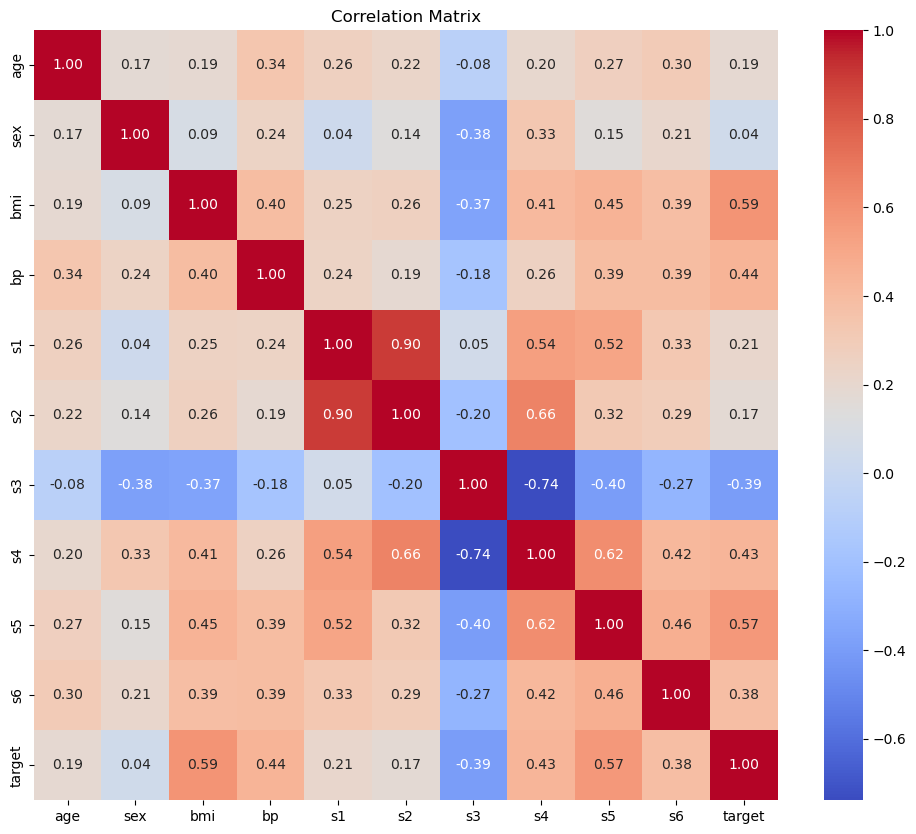

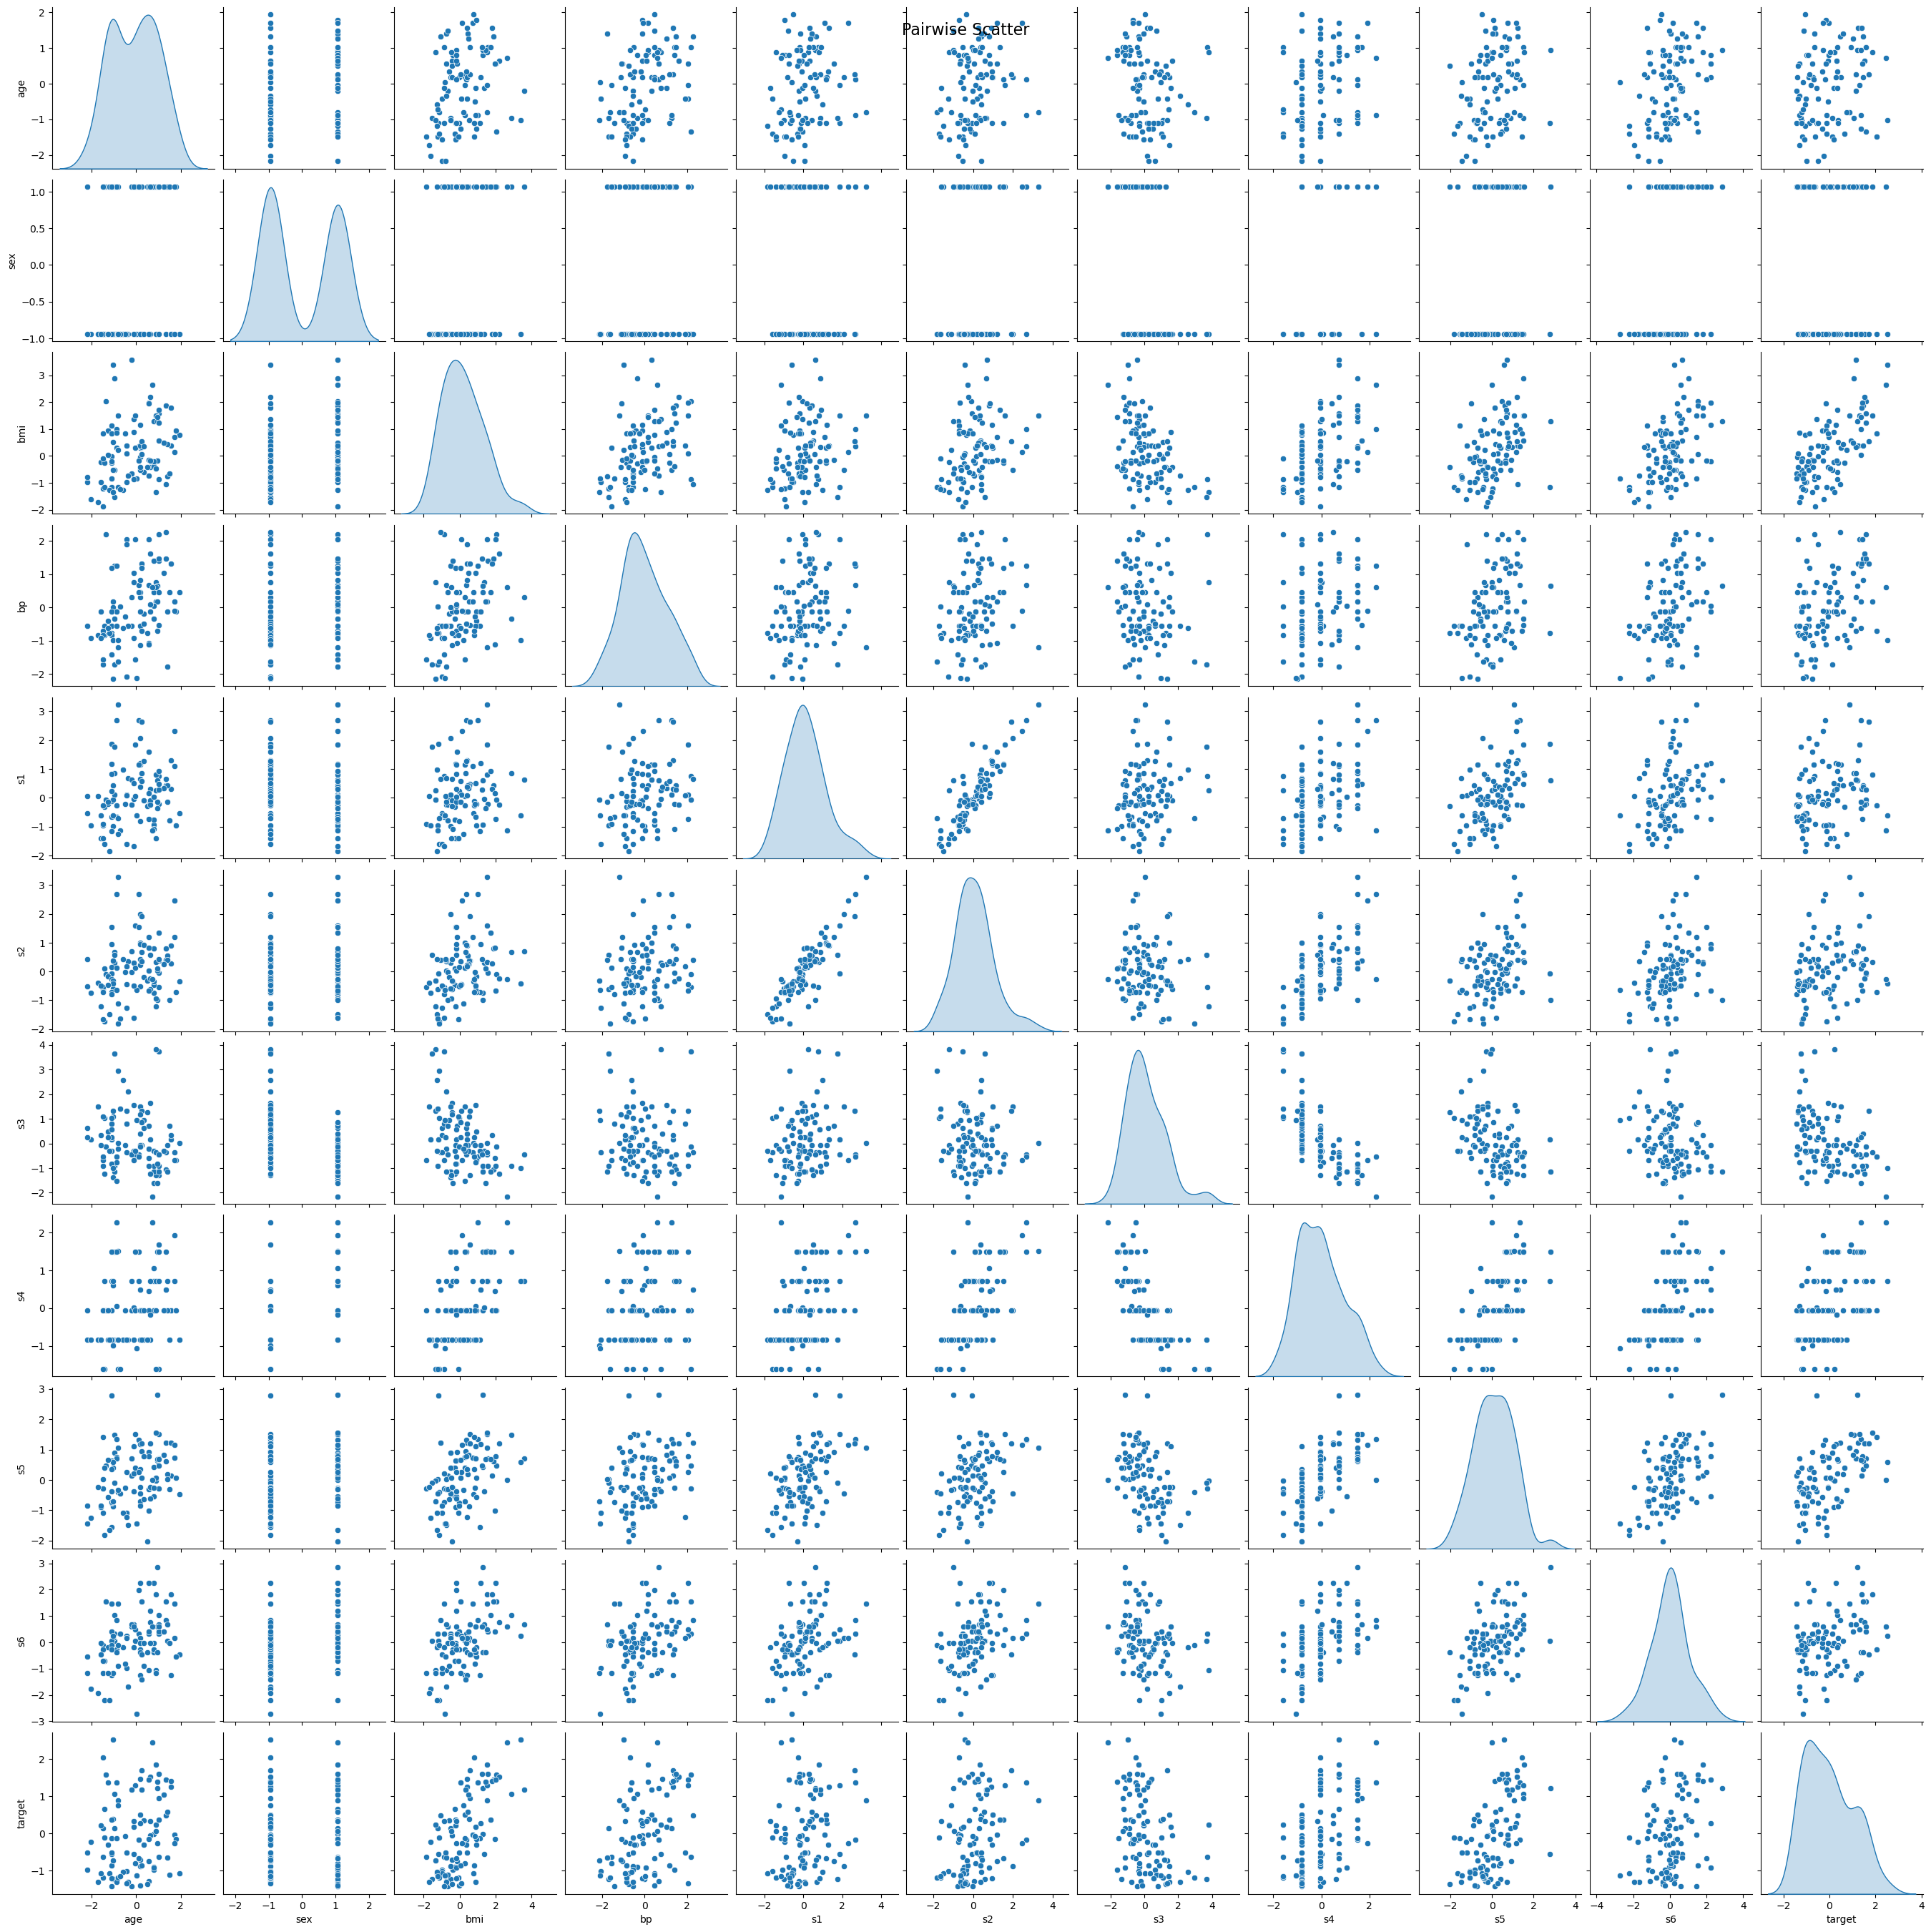

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

# Load the diabetes dataset as a dataframe
# X is already standardized 
data = load_diabetes(as_frame=True, scaled=False)
X = data.data  # Feature data as DataFrame
y = data.target  # Target data as Series


# Combine X and y into a single DataFrame for analysis
df = pd.concat([X, y.rename('target')], axis=1)

# Standardize the data
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

X = df.drop('target', axis=1)
y = df['target']

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

# Pairwise scatter plot
# sample 100 data points to make the plot clearer
sns.pairplot(df.sample(100), diag_kind='kde')
plt.suptitle('Pairwise Scatter', size=16)
plt.show()


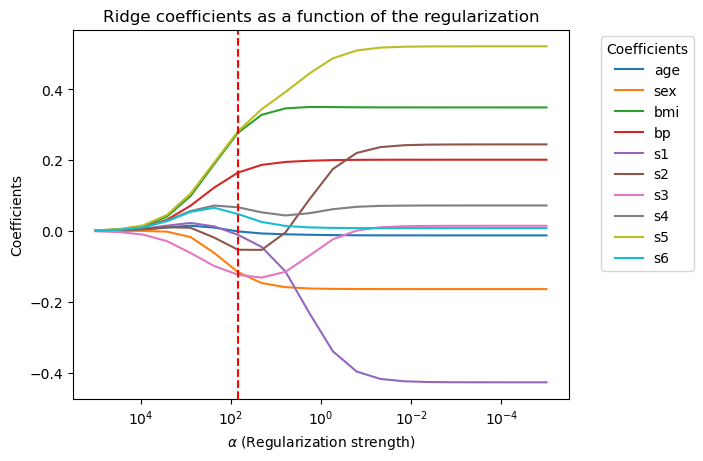

coefficient at min_test_error_alpha: [-0.00133414 -0.11633839  0.27727779  0.16477408 -0.01101457 -0.05313174
 -0.12380363  0.06682291  0.28140028  0.04766235]


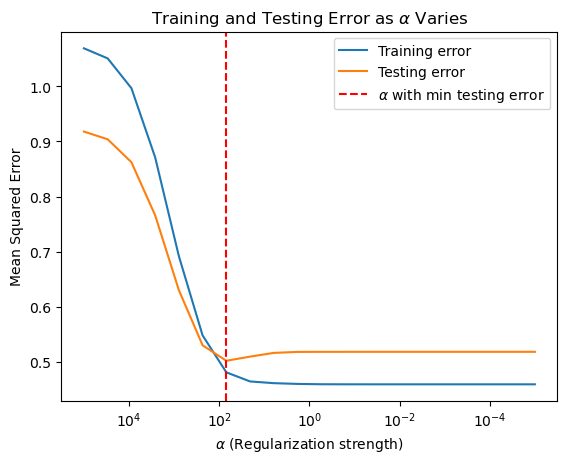

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Range of alpha values for regularization, from 10^2 to 10^-6
alphas = np.logspace(5, -5, 20)

# Array to store coefficients
coefficients = np.zeros((len(alphas), X_train.shape[1]))

# Lists to store training and testing errors
train_mse = []
test_mse = []

train_r2 = []
test_r2 = []

# Perform Ridge Regression with different values of alpha
for index, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    # Calculate training and testing errors
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)

    train_mse.append(mean_squared_error(y_train, y_train_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))

    train_r2.append(r2_score(y_train, y_train_pred))
    test_r2.append(r2_score(y_test, y_test_pred))
    
    # Store coefficients
    coefficients[index, :] = ridge.coef_

# Find the alpha value that minimizes the testing error
min_test_error_alpha = alphas[np.argmin(test_mse)]

# Plotting coefficients as a function of alpha
plt.figure()
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=X.columns[i])
plt.axvline(min_test_error_alpha, color='red', linestyle='--')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Coefficients')
plt.title('Ridge coefficients as a function of the regularization')
plt.legend(title="Coefficients", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

best_coef = coefficients[np.argmin(test_mse)]
print(f'coefficient at min_test_error_alpha: {best_coef}')

# Plotting training and testing error as a function of alpha
plt.figure()
plt.plot(alphas, train_mse, label='Training error')
plt.plot(alphas, test_mse, label='Testing error')
plt.axvline(min_test_error_alpha, color='red', linestyle='--', label=r'$\alpha$ with min testing error')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Mean Squared Error')
plt.title(r'Training and Testing Error as $\alpha$ Varies')
plt.legend()
plt.show()


## The Lasso

The lasso is another way to regularize the linear regression model. The optimization problem is:

$$
\min_{\beta}  \sum_{i=1}^N (\sum_{j=1}^p x_{ij} \beta_j - y_i)^2 + \alpha \sum_{j=1}^p |\beta_j|
$$

where $\alpha$ is the regularization strength.

We can also write the problem as a constrained optimization problem:

$$
\begin{align*}
&\min_{\beta}  \sum_{i=1}^N (\sum_{j=1}^p x_{ij} \beta_j - y_i)^2 \\
&\text{subject to} \sum_{j=1}^p |\beta_j| \leq t
\end{align*}
$$

Compared with ridge regression, the lasso tends to produce sparse solutions: it encourages the coefficients to be exactly 0. 
This is useful in practice because it can help us select a subset of the features.

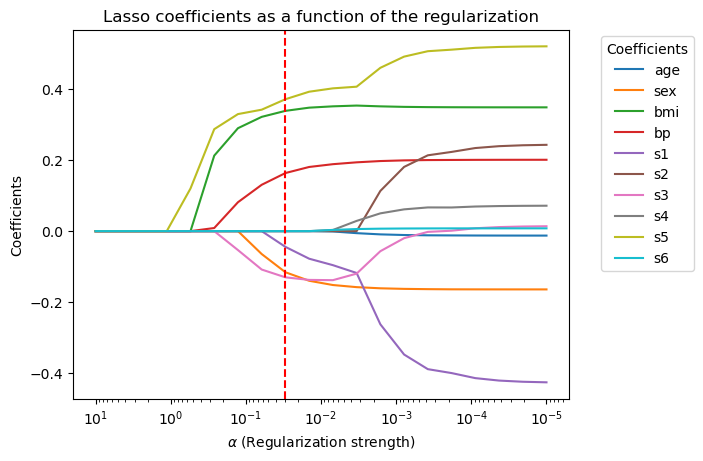

coefficient at min_test_error_alpha: [-0.         -0.11588826  0.33891449  0.16367789 -0.04436525 -0.
 -0.13020369  0.          0.37168991  0.        ]


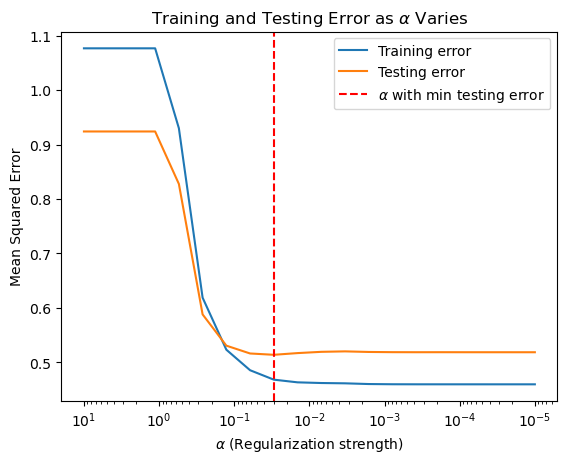

In [30]:
from sklearn.linear_model import Lasso

# Range of alpha values for regularization, from 10^2 to 10^-6
alphas = np.logspace(1, -5, 20)

# Array to store coefficients
coefficients = np.zeros((len(alphas), X_train.shape[1]))

# Lists to store training and testing errors
train_errors = []
test_errors = []

train_r2 = []
test_r2 = []

# Perform Lasso Regression with different values of alpha
for index, alpha in enumerate(alphas):
    ridge = Lasso(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    # Calculate training and testing errors
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))
    
    # Store coefficients
    coefficients[index, :] = ridge.coef_

# Find the alpha value that minimizes the testing error
min_test_error_alpha = alphas[np.argmin(test_errors)]

# Plotting coefficients as a function of alpha
plt.figure()
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=X.columns[i])
plt.axvline(min_test_error_alpha, color='red', linestyle='--')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients as a function of the regularization')
plt.legend(title="Coefficients", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

best_coef = coefficients[np.argmin(test_errors)]
print(f'coefficient at min_test_error_alpha: {best_coef}')

# Plotting training and testing error as a function of alpha
plt.figure()
plt.plot(alphas, train_errors, label='Training error')
plt.plot(alphas, test_errors, label='Testing error')
plt.axvline(min_test_error_alpha, color='red', linestyle='--', label=r'$\alpha$ with min testing error')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Mean Squared Error')
plt.title(r'Training and Testing Error as $\alpha$ Varies')
plt.legend()
plt.show()



## Some take away

- Both Lasso and Ridge regression are used to prevent overfitting in linear models.

- Both require the feature to be of the same scale.

- Ridge regression has a closed-form solution, while Lasso does not.

- Lasso tends to produce sparse solutions, that is, it encourages the coefficients to be exactly 0.

- The choice of $\alpha$ is important. It can be determined by cross-validation.

## Why does the Lasso prefer sparse solutions?

Consider the contrained optimization problem of the lasso and the ridge regression. We can visualize the constraints in 2 dimensions.

The elliptical contours are contours of the loss function, and the diamond and the circle region are the constraints.

For the ridge regression, the coefficients are constrained in a ball, while for the lasso, the coefficients are constrained in a diamond shape.

The optimal solution happens when the contours of the loss function are tangent to the constraints.

For the ridge regression, that usually happens at the boundary of the ball, where the coefficients are not 0. While for the lasso, that usually happens at the corner of the diamond, where some coefficients are 0.

![Figure Description](https://images.datacamp.com/image/upload/v1648205672/image18_a3zz7y.png)

[Souce](https://online.stat.psu.edu/stat508/book/export/html/749)